In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sys
from PIL import Image

def reload_functions():
  if 'models' in sys.modules:
    del sys.modules['models']
  functions_path = drive_path.replace(" ","\ ") + 'models.py'
  !cp $functions_path .

## 1. Data

Data in `train` is used for training and validation, and the data in `test_m` and `test_w`is used for testing.

The separation of `test_w` and `test_m` is to track our model performance
for women's shoes and men's shoes separately.

In [ ]:
from google.colab import drive
drive_path = '/content/gdrive/MyDrive/' # UPDATE ME BASED ON YOUR PATH
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.1 Loading and Preprocessing the data

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import os
import re
import glob


def load_and_augment_images(path, augment=True):
    images_dict = {}
    for file in glob.glob(path):
        filename = os.path.basename(file)
        img = Image.open(file).convert('RGB')
        if augment:
            img_augmented = img.transpose(method=Image.FLIP_LEFT_RIGHT)
            img_augmented = img_augmented.rotate(-90)
            img_augmented = np.asarray(img_augmented)[:, :, :3]
        else:
            img_augmented = None

        img = np.asarray(img)[:, :, :3]
        images_dict[filename] = (img, img_augmented)

    return images_dict

# Load train images with augmentation
path_train = os.path.join(drive_path, "data/train/*.jpg")
images_train = load_and_augment_images(path_train, augment=True)

# Load test images for 'w' without augmentation
path_test_w = os.path.join(drive_path, "data/test_w/*.jpg")
images_test_w = load_and_augment_images(path_test_w, augment=False)

# Load test images for 'm' without augmentation
path_test_m = os.path.join(drive_path, "data/test_m/*.jpg")
images_test_m = load_and_augment_images(path_test_m, augment=False)

# Extract triplet IDs
triplet_ids_train = sorted(set(re.match(r'(u\d+)', key).group(1) for key in images_train.keys()))
triplet_ids_test_w = sorted(set(re.match(r'(u\d+)', key).group(1) for key in images_test_w.keys() if '_w' in key))
triplet_ids_test_m = sorted(set(re.match(r'(u\d+)', key).group(1) for key in images_test_m.keys() if '_m' in key))

# Initialize data arrays
num_train = 80
num_valid = len(triplet_ids_train) - num_train
num_test_w = len(triplet_ids_test_w)
num_test_m = len(triplet_ids_test_m)

# Double the triplet counts for augmented data
num_train *= 2

train_data = np.zeros((num_train, 3, 2, 224, 224, 3), dtype=np.uint8)
valid_data = np.zeros((num_valid, 3, 2, 224, 224, 3), dtype=np.uint8)
test_w = np.zeros((num_test_w, 3, 2, 224, 224, 3), dtype=np.uint8)
test_m = np.zeros((num_test_m, 3, 2, 224, 224, 3), dtype=np.uint8)

# Assign data to arrays
def assign_data(data_array, triplet_ids, images_dict, offset=0, augment=True):
    for i, triplet_id in enumerate(triplet_ids):
        for j in range(3):  # 3 pairs
            for side in ['left', 'right']:
                key_w = f'{triplet_id}_{j+1}_{side}_w.jpg'
                key_m = f'{triplet_id}_{j+1}_{side}_m.jpg'

                if key_w in images_dict:
                    img_original, img_augmented = images_dict[key_w]

                    # Original image assignment
                    data_array[i + offset, j, 0 if side == 'left' else 1] = img_original

                    if augment and img_augmented is not None:
                        # Augmented image assignment to new ID
                        data_array[i + len(triplet_ids) + offset, j, 1 if side == 'left' else 0] = img_augmented

                elif key_m in images_dict:
                    img_original, img_augmented = images_dict[key_m]

                    # Original image assignment
                    data_array[i + offset, j, 0 if side == 'left' else 1] = img_original

                    if augment and img_augmented is not None:
                        # Augmented image assignment to new ID
                        data_array[i + len(triplet_ids) + offset, j, 1 if side == 'left' else 0] = img_augmented

# Split triplets into training and validation sets
train_triplets = triplet_ids_train[:num_train//2]
valid_triplets = triplet_ids_train[num_train//2:num_train//2 + num_valid]

# Assign data to arrays
assign_data(train_data, train_triplets, images_train, augment=True)
assign_data(valid_data, valid_triplets, images_train, augment=False)
assign_data(test_w, triplet_ids_test_w, images_test_w, augment=False)
assign_data(test_m, triplet_ids_test_m, images_test_m, augment=False)

# Normalization function
def normalize_data(data_array):
    data_array = (data_array / 255.0) - 0.5
    return data_array

# Normalize data arrays
train_data = normalize_data(train_data)
valid_data = normalize_data(valid_data)
test_w = normalize_data(test_w)
test_m = normalize_data(test_m)

# Printing shapes for verification
print('Train data shape:', train_data.shape)
print('Validation data shape:', valid_data.shape)
print('Test (w) data shape:', test_w.shape)
print('Test (m) data shape:', test_m.shape)




Train data shape: (160, 3, 2, 224, 224, 3)
Validation data shape: (32, 3, 2, 224, 224, 3)
Test (w) data shape: (10, 3, 2, 224, 224, 3)
Test (m) data shape: (10, 3, 2, 224, 224, 3)


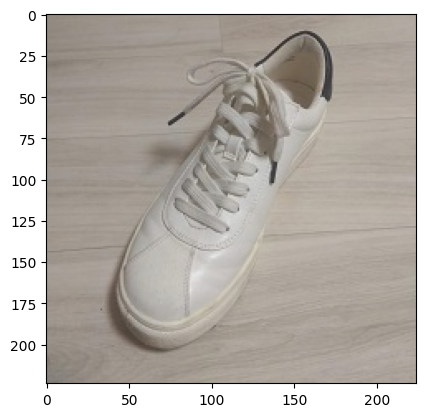

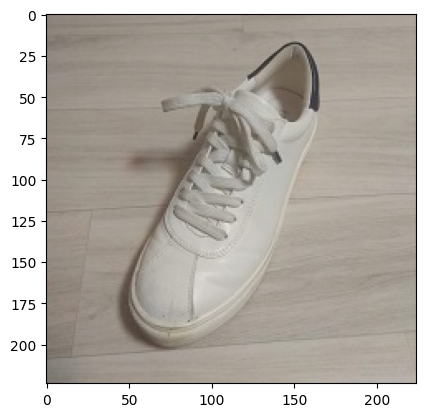

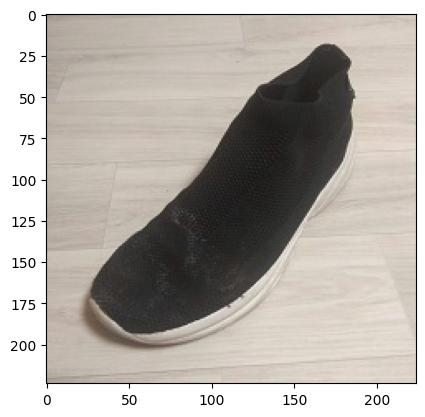

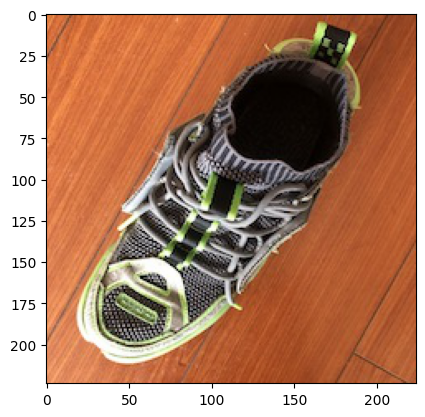

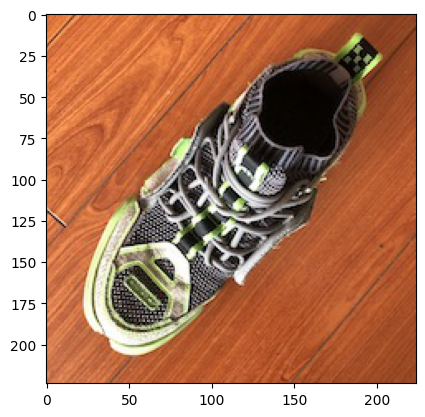

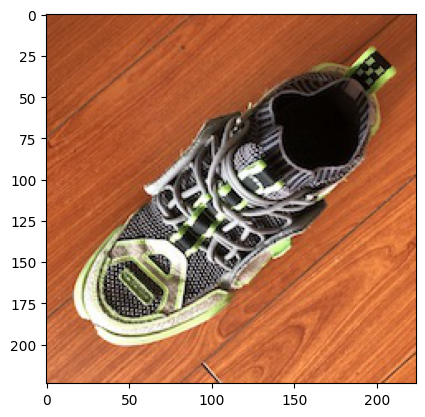

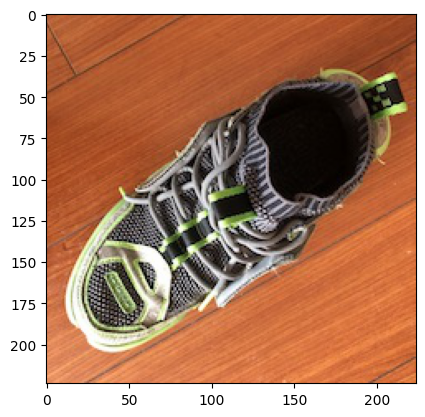

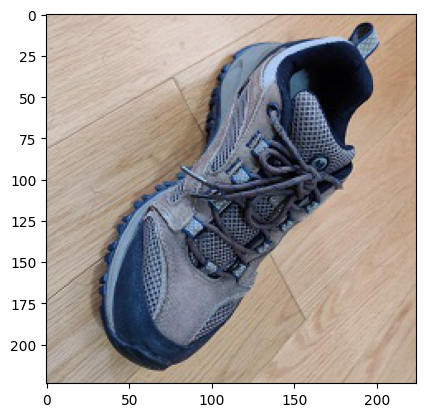

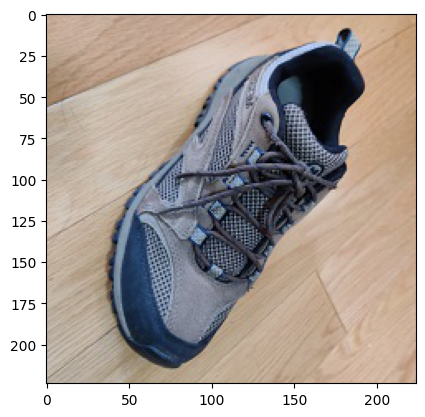

In [ ]:
# code to test data preprocessing
test1 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,0,:,:,:]).any() or \
   (test2 != train_data[4,0,1,:,:,:]).any() or \
   (test3 != train_data[4,1,1,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### 1.2 Generating Same Pairs

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
*positive examples* are images containing two shoes that *are* from the same pair, and some *negative examples* where images containing two shoes that *are not* from the same pair.


(160, 3, 2, 224, 224, 3)
(480, 448, 224, 3)


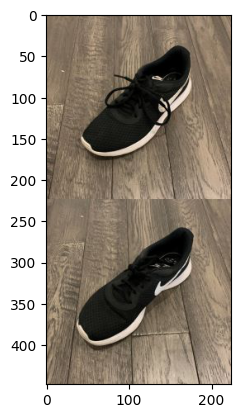

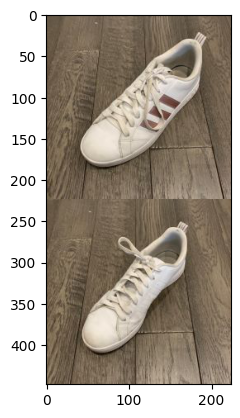

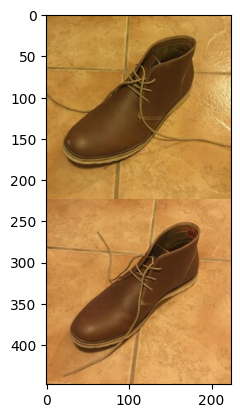

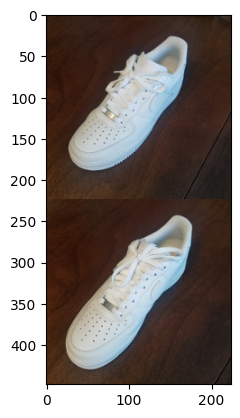

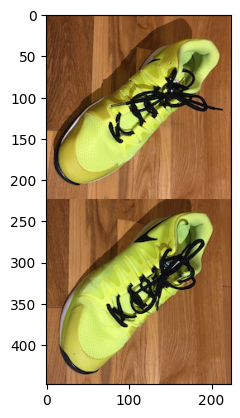

In [ ]:
def generate_same_pair(data_array):
  same_pair_array = np.zeros((len(data_array)*3, 448, 224, 3), dtype=np.float32)
  for i in range(len(data_array)):
    for j in range(3):
      same_pair_array[i * 3 + j, :224, :, :] = data_array[i, j, 0, :, :, :]  # left shoe
      same_pair_array[i * 3 + j, 224:, :, :] = data_array[i, j, 1, :, :, :]  # right shoe

  return same_pair_array

# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.figure()
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### 1.3 Generate Different Pairs


(160, 3, 2, 224, 224, 3)
(480, 448, 224, 3)
(96, 448, 224, 3)


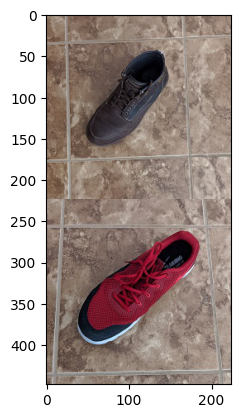

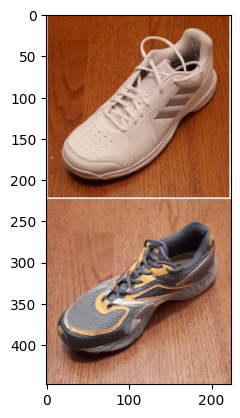

In [ ]:
import random

def generate_different_pair(data_array):
    different_pair_array = np.zeros((len(data_array) * 3, 448, 224, 3), dtype=np.float32)
    for i in range(len(data_array)):
        options = [
            (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)
        ]
        selected_pairs = random.sample(options, 3)

        for j, (left_index, right_index) in enumerate(selected_pairs):
            different_pair_array[i * 3 + j, :224, :, :] = data_array[i, left_index, 0, :, :, :]  # left shoe
            different_pair_array[i * 3 + j, 224:, :, :] = data_array[i, right_index, 1, :, :, :]  # right shoe

    return different_pair_array

print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.figure()
plt.imshow(generate_different_pair(train_data)[20]+0.5) # should show 2 shoes from different pairs
print(generate_different_pair(valid_data).shape) # should be [N*3, 448, 224, 3]
plt.figure()
plt.imshow(generate_different_pair(valid_data)[20]+0.5) # should show 2 shoes from different pairs

## 2. Convolutional Neural Networks


### 2.1 Convolutional Model

The models file(models.py) contains an implementation of a CNN model in PyTorch called `CNN` that takes images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model contains the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

### 2.2 Channeled Convolutional Neural Network

Tthe models file(models.py) contains an implementation a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />

### 2.3 Get Accuracy


In [ ]:
def get_accuracy(model, data, batch_size=50,device='cpu'):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]


    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## 3. Training

### 3.1 training loop

In [ ]:
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch

def train(model,
                       train_data=train_data,
                       validation_data=valid_data,
                       subset_size=5,  # Adjust subset size as needed
                       batch_size=32,
                       learning_rate=0.001,
                       weight_decay=0.0,
                       epochs=20,  # Ensure this matches your desired number of epochs
                       checkpoint_path=None,
                       device='cpu'):

    model = model.to(device)  # Move model to device

    # Initialize Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Create the positive and negative pairs
    positive_pairs = generate_same_pair(train_data)
    negative_pairs = generate_different_pair(train_data)

    train_loss_history = []
    train_acc_history_pos = []
    train_acc_history_neg = []
    valid_acc_history_pos = []
    valid_acc_history_neg = []

    # Subset of training data
    train_subset = subset_data(train_data, subset_size)

    for epoch in range(epochs):
        epoch_train_loss = 0.0
        total_batches = 0

        # Shuffle the positive and negative pairs
        np.random.shuffle(positive_pairs)
        np.random.shuffle(negative_pairs)

        for i in range(0, len(positive_pairs), batch_size):
            data_batch = []
            label_batch = []
            label_batch[:(batch_size // 2)] = np.ones(batch_size // 2)
            label_batch[(batch_size // 2):] = np.zeros(batch_size // 2)

            for j in range(batch_size):
                if len(data_batch) < batch_size // 2:
                    data_batch.append(positive_pairs[i + j])
                else:
                    data_batch.append(negative_pairs[i + j - (batch_size // 2)])

            # Conversion from numpy array to torch tensor and move to device
            torch_tensor_data = torch.tensor(data_batch, dtype=torch.float32).to(device)
            torch_tensor_data = torch_tensor_data.permute(0, 3, 1, 2)  # Ensure correct dimension ordering
            torch_tensor_labels = torch.tensor(label_batch, dtype=torch.long).to(device)

            # Reset the optimizer
            optimizer.zero_grad()

            # Forward pass
            outputs = model(torch_tensor_data)

            # Compute the loss
            loss = criterion(outputs, torch_tensor_labels)

            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Accumulate the loss
            epoch_train_loss += loss.item()
            total_batches += 1

        # Calculate and record the average training loss for the epoch
        avg_train_loss = epoch_train_loss / total_batches
        train_loss_history.append(avg_train_loss)

        # Track the accuracy
        train_accuracy_pos, train_accuracy_neg = get_accuracy(model, train_subset, batch_size=batch_size, device=device)
        train_acc_history_pos.append(train_accuracy_pos)
        train_acc_history_neg.append(train_accuracy_neg)

        # Validation after each epoch
        valid_accuracy_pos, valid_accuracy_neg = get_accuracy(model, validation_data, batch_size=batch_size, device=device)
        valid_acc_history_pos.append(valid_accuracy_pos)
        valid_acc_history_neg.append(valid_accuracy_neg)

        # Print current training status
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}")
        print(f"Train Accuracy (Positive): {train_accuracy_pos:.4f}, (Negative): {train_accuracy_neg:.4f}")
        print(f"Validation Accuracy (Positive): {valid_accuracy_pos:.4f}, (Negative): {valid_accuracy_neg:.4f}")

        # Checkpoint the model if checkpoint_path is provided
        if checkpoint_path is not None:
            epoch_checkpoint_path = f"{checkpoint_path}_epoch_{epoch+1}.pk"
            torch.save(model.state_dict(), epoch_checkpoint_path)

    print("Training finished.")

    return train_loss_history, train_acc_history_pos, train_acc_history_neg, valid_acc_history_pos, valid_acc_history_neg

# Function to subset data
def subset_data(data, size):
    return data[:size]

### 3.2 training and saving the optimal model



True
Training of CNN-channel


<ipython-input-9-901365fb7f72>:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch_tensor_data = torch.tensor(data_batch, dtype=torch.float32).to(device)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/35], Loss: 0.7584
Train Accuracy (Positive): 0.8771, (Negative): 0.4646
Validation Accuracy (Positive): 0.9167, (Negative): 0.4792
Epoch [2/35], Loss: 0.7783
Train Accuracy (Positive): 0.7917, (Negative): 0.6771
Validation Accuracy (Positive): 0.7917, (Negative): 0.6458
Epoch [3/35], Loss: 0.4988
Train Accuracy (Positive): 0.9271, (Negative): 0.6458
Validation Accuracy (Positive): 0.8854, (Negative): 0.5833
Epoch [4/35], Loss: 0.4043
Train Accuracy (Positive): 0.8708, (Negative): 0.7896
Validation Accuracy (Positive): 0.8438, (Negative): 0.7708
Epoch [5/35], Loss: 0.4326
Train Accuracy (Positive): 0.9417, (Negative): 0.6354
Validation Accuracy (Positive): 0.9167, (Negative): 0.6979
Epoch [6/35], Loss: 0.3854
Train Accuracy (Positive): 0.8542, (Negative): 0.7896
Validation Accuracy (Positive): 0.8438, (Negative): 0.7917
Epoch [7/35], Loss: 0.3372
Train Accuracy (Positive): 0.8146, (Negative): 0.8708
Validation Accuracy (Positive): 0.7812, (Negative): 0.8438
Epoch [8/35], Loss: 

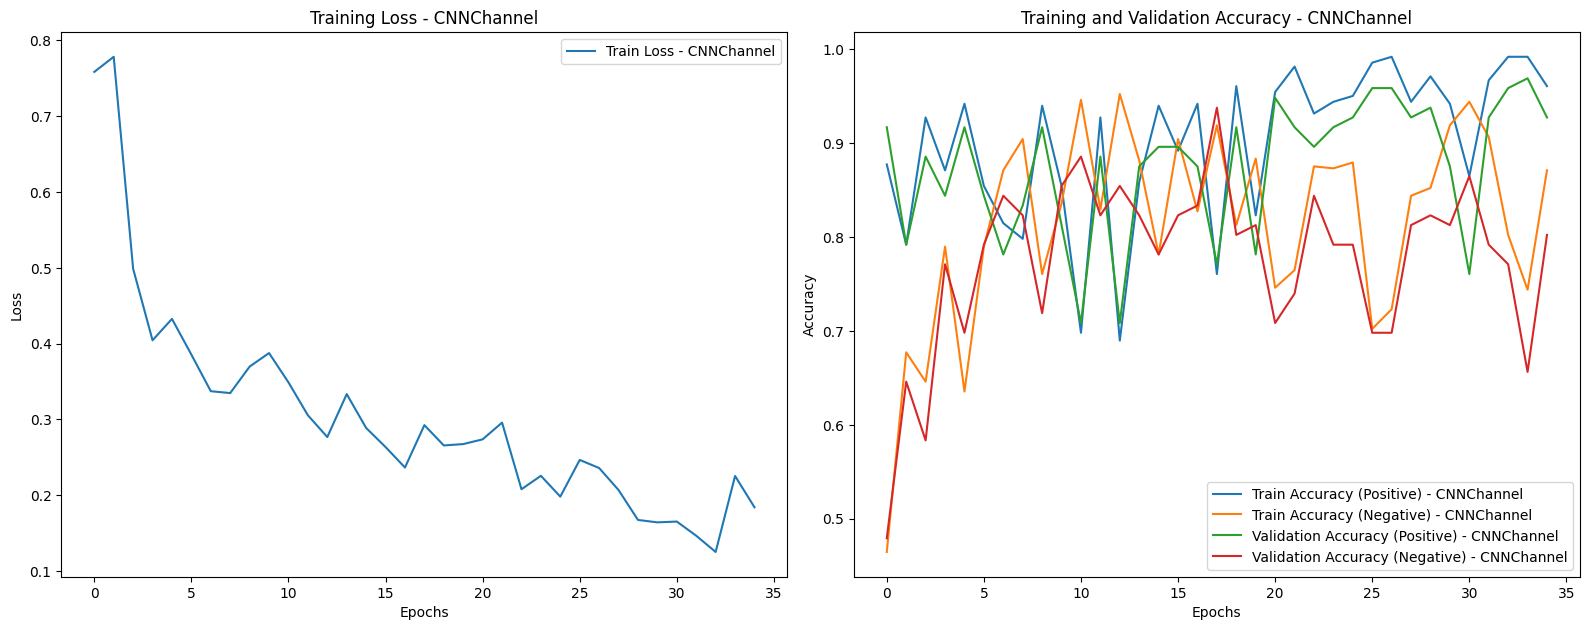

Train of CNN


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/35], Loss: 0.8764
Train Accuracy (Positive): 0.0000, (Negative): 1.0000
Validation Accuracy (Positive): 0.0000, (Negative): 1.0000
Epoch [2/35], Loss: 0.7188
Train Accuracy (Positive): 0.0000, (Negative): 0.9979
Validation Accuracy (Positive): 0.0000, (Negative): 1.0000
Epoch [3/35], Loss: 0.7074
Train Accuracy (Positive): 0.2875, (Negative): 0.7208
Validation Accuracy (Positive): 0.2812, (Negative): 0.7188
Epoch [4/35], Loss: 0.6936
Train Accuracy (Positive): 0.6333, (Negative): 0.4271
Validation Accuracy (Positive): 0.5833, (Negative): 0.4271
Epoch [5/35], Loss: 0.6817
Train Accuracy (Positive): 0.2854, (Negative): 0.8417
Validation Accuracy (Positive): 0.3229, (Negative): 0.7812
Epoch [6/35], Loss: 0.6394
Train Accuracy (Positive): 0.5938, (Negative): 0.7917
Validation Accuracy (Positive): 0.5625, (Negative): 0.7500
Epoch [7/35], Loss: 0.6378
Train Accuracy (Positive): 0.9771, (Negative): 0.2083
Validation Accuracy (Positive): 0.9583, (Negative): 0.2396
Epoch [8/35], Loss: 

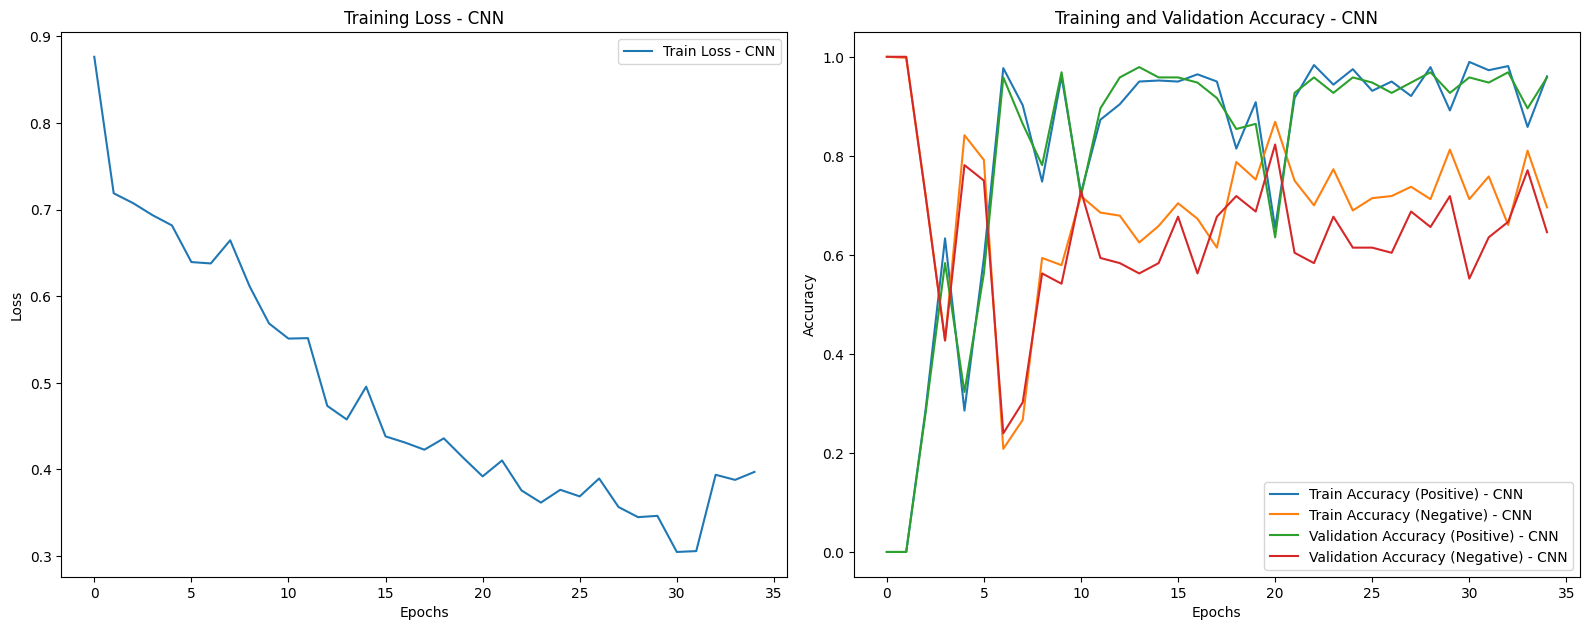

In [ ]:
reload_functions()
import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
CNN_model = models.CNN()
CNNChannel_model = models.CNNChannel()

checkpoint_path_cnn = drive_path + "checkpoints/best_CNN_model"
checkpoint_path_cnnchannel = drive_path + "checkpoints/best_CNNChannel_model"

print("Training of CNN-channel")
# Train CNNChannel model
train_loss_cnnchannel, train_acc_pos_cnnchannel, train_acc_neg_cnnchannel, valid_acc_pos_cnnchannel, valid_acc_neg_cnnchannel = train(
    CNNChannel_model,
    train_data=train_data,
    validation_data=valid_data,
    subset_size=None,
    batch_size=64,
    learning_rate=0.001,
    weight_decay=0.0005,
    epochs=35,
    checkpoint_path=checkpoint_path_cnnchannel,
    device=device
)

# Plotting the training curves for CNN channel model
plt.figure(figsize=(16, 12))

# Loss curves for CNNChannel
plt.subplot(2, 2, 3)
plt.plot(train_loss_cnnchannel, label='Train Loss - CNNChannel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss - CNNChannel')
plt.legend()

# Accuracy curves for CNNChannel
plt.subplot(2, 2, 4)
plt.plot(train_acc_pos_cnnchannel, label='Train Accuracy (Positive) - CNNChannel')
plt.plot(train_acc_neg_cnnchannel, label='Train Accuracy (Negative) - CNNChannel')
plt.plot(valid_acc_pos_cnnchannel, label='Validation Accuracy (Positive) - CNNChannel')
plt.plot(valid_acc_neg_cnnchannel, label='Validation Accuracy (Negative) - CNNChannel')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - CNNChannel')
plt.legend()

plt.tight_layout()
plt.show()

print("Train of CNN")
# Train CNN model
train_loss_cnn, train_acc_pos_cnn, train_acc_neg_cnn, valid_acc_pos_cnn, valid_acc_neg_cnn = train(
     CNN_model,
     train_data=train_data,
     validation_data=valid_data,
     subset_size=None,
     batch_size=64,
     learning_rate=0.001,
     weight_decay=0.0005,
     epochs=35,
     checkpoint_path=checkpoint_path_cnn,
     device=device
 )

# Plotting the training curves for CNN model
plt.figure(figsize=(16, 12))

# Loss curves for CNN
plt.subplot(2, 2, 1)
plt.plot(train_loss_cnn, label='Train Loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss - CNN')
plt.legend()
# # Accuracy curves for CNN
plt.subplot(2, 2, 2)
plt.plot(train_acc_pos_cnn, label='Train Accuracy (Positive) - CNN')
plt.plot(train_acc_neg_cnn, label='Train Accuracy (Negative) - CNN')
plt.plot(valid_acc_pos_cnn, label='Validation Accuracy (Positive) - CNN')
plt.plot(valid_acc_neg_cnn, label='Validation Accuracy (Negative) - CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - CNN')
plt.legend()

plt.tight_layout()
plt.show()


## 4. Testing

In [ ]:
reload_functions()
import models
import torch
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the best models
CNN_model = models.CNN()
CNNChannel_model = models.CNNChannel()

# Define paths to your checkpoints
checkpoint_path_cnn = drive_path + "checkpoints/best_CNN_model.pk"
checkpoint_path_cnnchannel = drive_path + "checkpoints/best_CNNChannel_model.pk"

# Load the model weights and move models to device
CNN_model.load_state_dict(torch.load(checkpoint_path_cnn, map_location=device))
CNNChannel_model.load_state_dict(torch.load(checkpoint_path_cnnchannel, map_location=device))
CNN_model.to(device)
CNNChannel_model.to(device)

# Evaluate the CNN model
test_w_accuracy_pos_cnn, test_w_accuracy_neg_cnn = get_accuracy(CNN_model, test_w, batch_size=64, device=device)
test_m_accuracy_pos_cnn, test_m_accuracy_neg_cnn = get_accuracy(CNN_model, test_m, batch_size=64, device=device)

# Evaluate the CNNChannel model
test_w_accuracy_pos_cnnchannel, test_w_accuracy_neg_cnnchannel = get_accuracy(CNNChannel_model, test_w, batch_size=64, device=device)
test_m_accuracy_pos_cnnchannel, test_m_accuracy_neg_cnnchannel = get_accuracy(CNNChannel_model, test_m, batch_size=64, device=device)

print(f"CNN Model - Women's Shoes Accuracy (Positive): {test_w_accuracy_pos_cnn:.4f}, (Negative): {test_w_accuracy_neg_cnn:.4f}")
print(f"CNN Model - Men's Shoes Accuracy (Positive): {test_m_accuracy_pos_cnn:.4f}, (Negative): {test_m_accuracy_neg_cnn:.4f}")

print(f"CNNChannel Model - Women's Shoes Accuracy (Positive): {test_w_accuracy_pos_cnnchannel:.4f}, (Negative): {test_w_accuracy_neg_cnnchannel:.4f}")
print(f"CNNChannel Model - Men's Shoes Accuracy (Positive): {test_m_accuracy_pos_cnnchannel:.4f}, (Negative): {test_m_accuracy_neg_cnnchannel:.4f}")


CNN Model - Women's Shoes Accuracy (Positive): 0.8667, (Negative): 0.7000
CNN Model - Men's Shoes Accuracy (Positive): 0.8333, (Negative): 0.7000
CNNChannel Model - Women's Shoes Accuracy (Positive): 0.9333, (Negative): 0.7667
CNNChannel Model - Men's Shoes Accuracy (Positive): 0.7667, (Negative): 0.8333


### Men's Shoes example


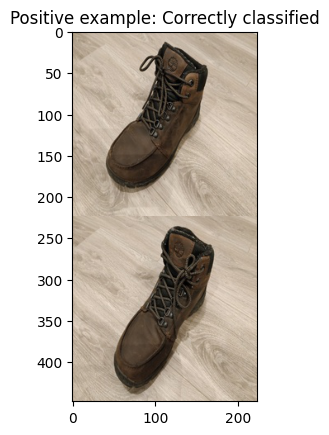

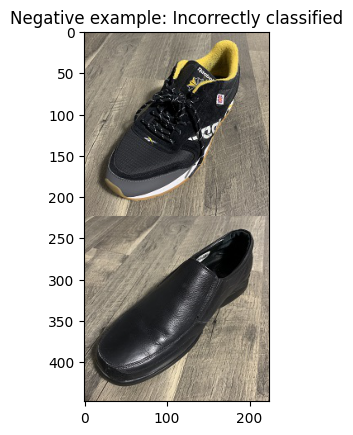

In [ ]:
# Generate positive and negative pairs
data_pos = generate_same_pair(test_m)
data_neg = generate_different_pair(test_m)

is_shown_correct = False
is_shown_incorrect = False

# Randomly select one correctly classified pair
rand_pos_idx = random.randint(0, len(data_pos) - 1)
xs_pos = torch.Tensor(data_pos[rand_pos_idx:rand_pos_idx+1]).transpose(1, 3).to(device)  # Move to device and format
zs_pos = CNN_model(xs_pos)
pred_pos = zs_pos.max(1, keepdim=True)[1].detach().cpu().numpy()  # Get the predicted class index

# Display correctly classified positive example
plt.figure()
plt.imshow(data_pos[rand_pos_idx] + 0.5)  # Adjust brightness or normalization as needed
plt.title("Positive example: Correctly classified")

# Randomly select one incorrectly classified pair
rand_neg_idx = random.randint(0, len(data_neg) - 1)
xs_neg = torch.Tensor(data_neg[rand_neg_idx:rand_neg_idx+1]).transpose(1, 3).to(device)  # Move to device and format
zs_neg = CNN_model(xs_neg)
pred_neg = zs_neg.max(1, keepdim=True)[1].detach().cpu().numpy()  # Get the predicted class index

# Display incorrectly classified negative example
plt.figure()
plt.imshow(data_neg[rand_neg_idx] + 0.5)  # Adjust brightness or normalization as needed
plt.title("Negative example: Incorrectly classified")

plt.show()



### Women's Shoes example


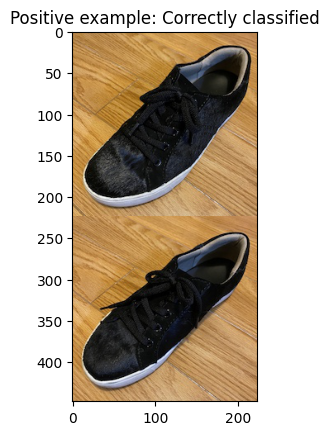

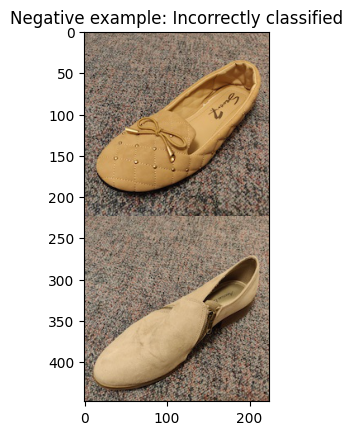

In [ ]:
# Generate positive and negative pairs
data_pos = generate_same_pair(test_w)
data_neg = generate_different_pair(test_w)

is_shown_correct = False
is_shown_incorrect = False

# Randomly select one correctly classified pair
rand_pos_idx = random.randint(0, len(data_pos) - 1)
xs_pos = torch.Tensor(data_pos[rand_pos_idx:rand_pos_idx+1]).transpose(1, 3).to(device)  # Assuming data_pos is correctly formatted
zs_pos = CNN_model(xs_pos)
pred_pos = zs_pos.max(1, keepdim=True)[1].detach().cpu().numpy()  # Get the predicted class index

# Display correctly classified positive example
plt.figure()
plt.imshow(data_pos[rand_pos_idx] + 0.5)  # Adjust brightness or normalization as needed
plt.title("Positive example: Correctly classified")

# Randomly select one incorrectly classified pair
rand_neg_idx = random.randint(0, len(data_neg) - 1)
xs_neg = torch.Tensor(data_neg[rand_neg_idx:rand_neg_idx+1]).transpose(1, 3).to(device)  # Assuming data_neg is correctly formatted
zs_neg = CNN_model(xs_neg)
pred_neg = zs_neg.max(1, keepdim=True)[1].detach().cpu().numpy()  # Get the predicted class index

# Display incorrectly classified negative example
plt.figure()
plt.imshow(data_neg[rand_neg_idx] + 0.5)  # Adjust brightness or normalization as needed
plt.title("Negative example: Incorrectly classified")

plt.show()